In [321]:
import json
import bz2
import regex
import re
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk import FreqDist
from tqdm import tqdm
from scipy import sparse
from pymystem3 import Mystem
from string import punctuation
from sklearn.feature_extraction.text import TfidfTransformer
from gensim.models import word2vec
from sklearn.manifold import TSNE


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:26, 2321.40it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

Составление словарей для классификации по тональности

При классификации текстов или предложений по тональности необходимо использовать оценочные словари для предметной области, то есть, такие словари, в которых содержатся отрицательные и позитивные слова для какой-то предметной области. Идея подобных словарей основана на следующих наблюдениях: во-первых, для разных товаров используются разные оценочные слова (например бывает “захватывающая книга”, но не бывает “захватывающих лыж”), во-вторых, в контексте разных товаров одни и те же слова могут иметь разную окраску (слово “тормоз” в отзыве на велосипед имеет нейтральную окраску, в отзыве на компьютер – резко негативную, “пыль” в контексте пылесосов – нейтральную, в контексте кофемолок – положительную (“мелкий помол в пыль”)). Еще один пример: “теплое пиво” – это плохо, а “теплый свитер” – это хорошо.

Составление таких словарей в ручную – трудоемкий процесс, но, к счастью, его не сложно автоматизировать, если собрать достаточно большие корпуса отзывов. В этом домашнем задании вам предстоит попробовать реализовать один их подходов к составлению оценочных словарей, основанный на статье Inducing Domain-Specific Sentiment Lexicons from Unlabeled Corpora (https://nlp.stanford.edu/pubs/hamilton2016inducing.pdf).

Данные для задания – уже знакомые вам отзывы на банки, собранные с нескольких сайтов Рунета. Отзывы могут быть как положительными (оценка 5), так и отрицательными (оценка 1).

________

Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
Обучите по коллекции предложений word2vec

Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:
    тест на определение ближайших слов
    тест на аналогии (мужчина – король : женщина – королева)
    тест на определение лишнего слова.

Постройте несколько визуализаций:
    * TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
    * задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.
    
    
Ссылка на примеры визуализаций: https://towardsdatascience.com/game-of-thrones-word-embeddings-does-r-l-j-part-2-30290b1c0b4b

_____

In [3]:
data = pd.DataFrame(responses)

In [4]:
data.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


# 1

**Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова. Обучите по коллекции предложений word2vec**

In [91]:
m = Mystem()
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")

In [92]:
def text_to_sentences(text, remove_stopwords = False):
    raw_sentences = nltk.sent_tokenize(text.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(sentence_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [93]:
def sentence_to_wordlist(text, remove_stopwords = False):  
    text = re.findall(ru_words, text.lower())
    text = ''.join(m.lemmatize(' '.join(text))).strip() 
    
    if remove_stopwords:
        text = ' '.join([token for token in text.split() if not token in mystopwords])
    return(text.split())

Предложения вместе со стоп-словами:

In [94]:
sentences = []  

for index, row in tqdm(data.iterrows(), total = len(data)):
    sentences += text_to_sentences(row['text'])

100%|██████████| 153499/153499 [36:07<00:00, 70.81it/s] 


In [275]:
print(f'{len(sentences)} предложений')
print(sentences[1])

2664456 предложений
['я', 'не', 'являться', 'клиент', 'банк', 'и', 'поручитель', 'по', 'кредитный', 'договор', 'а', 'также', 'не', 'являться', 'какой', 'либо', 'другой', 'лицо', 'письменно', 'оформлять', 'отношение', 'с', 'банк', 'по', 'повод', 'урегулирование', 'чей', 'либо', 'задолженность']


In [99]:
%time
model = word2vec.Word2Vec(sentences, workers=4, size=300, min_count=10, window=10, sample=1e-3)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs


In [273]:
print(f'{len(model.wv.vocab)} слов в модели')

23461 слов в модели


Предложения без стоп-слов:

In [103]:
sentences_stop = []  

for index, row in tqdm(data.iterrows(), total = len(data)):
    sentences_stop += text_to_sentences(row['text'], True)

100%|██████████| 153499/153499 [35:29<00:00, 72.08it/s]  


In [276]:
print(f'{len(sentences_stop)} предложений')
print(sentences_stop[1])

2664456 предложений
['являться', 'клиент', 'банк', 'поручитель', 'кредитный', 'договор', 'являться', 'либо', 'лицо', 'письменно', 'оформлять', 'отношение', 'банк', 'повод', 'урегулирование', 'чей', 'либо', 'задолженность']


In [105]:
%time
model_stop = word2vec.Word2Vec(sentences_stop, workers=4, size=300, min_count=10, window=10, sample=1e-3)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 21.9 µs


In [272]:
print(f'{len(model_stop.wv.vocab)} слов в модели')

23327 слов в модели


# 2

**Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:**
- тест на определение ближайших слов 
- тест на аналогии (мужчина – король : женщина – королева) 
- тест на определение лишнего слова.

**Тест на определение ближайших слов**

Удачные примеры:

In [224]:
print(model.wv.most_similar("кредит", topn=3))
print(model.wv.most_similar("очередь", topn=3))
print(model.wv.most_similar("услуга", topn=3))

[('автокредит', 0.8163735270500183), ('потребкредит', 0.7291420102119446), ('ипотека', 0.6849713325500488)]
[('толпа', 0.669745683670044), ('окошко', 0.5451444983482361), ('кабинка', 0.5325053930282593)]
[('опция', 0.6394367218017578), ('допуслуга', 0.597000241279602), ('сервис', 0.5550858974456787)]


Неудачные примеры:

In [225]:
print(model.wv.most_similar("колено", topn=3))
print(model.wv.most_similar("скала", topn=3))
print(model.wv.most_similar("пульт", topn=3))

[('победный', 0.5011315941810608), ('луна', 0.4890047311782837), ('лампочка', 0.4868699014186859)]
[('перевертываться', 0.39619314670562744), ('рыженький', 0.3910449743270874), ('операцианистка', 0.3813927173614502)]
[('боковой', 0.5142771005630493), ('лестница', 0.49868351221084595), ('уборщица', 0.4897913932800293)]


**Тест на аналогии**

Удачные примеры:

In [202]:
print(model.wv.most_similar(positive=["женщина", "кассир"], negative=["мужчина"], topn=1))
print(model.wv.most_similar(positive=["дол", "рубль"], negative=["руб"], topn=1))
print(model.wv.most_similar(positive=["украина", "москва"], negative=["россия"], topn=1))

[('кассирша', 0.7082198858261108)]
[('доллар', 0.6755964756011963)]
[('киев', 0.6492500305175781)]


Неудачные примеры:

In [249]:
print(model.wv.most_similar(positive=["мужчина", "уборщица"], negative=["женщина"], topn=1))
print(model.wv.most_similar(positive=["мужчина", "королева"], negative=["женщина"], topn=1))
print(model.wv.most_similar(positive=["франция", "москва"], negative=["россия"], topn=1))

[('курить', 0.6674877405166626)]
[('дзержинский', 0.7117281556129456)]
[('владивосток', 0.6216447353363037)]


**Тест на определение лишнего слова**

Удачные примеры:

In [211]:
print(model.wv.doesnt_match("кредит депозит вклад сотрудник".split()))
print(model.wv.doesnt_match("деньги кошелек сумма касса".split()))
print(model.wv.doesnt_match("доллар деньги евро рубль".split()))

сотрудник
касса
деньги


Неудачные примеры:

In [243]:
print(model.wv.doesnt_match("москва санкт-петербург область владивосток".split()))
print(model.wv.doesnt_match("золото серебро бронза монета".split()))
print(model.wv.doesnt_match("завтрак обед ужин курить".split()))

владивосток
серебро
завтрак


# 3

**Постройте несколько визуализаций:**
* TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
* задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально: берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

## 3.1

Визуализации будем строить для предложений без стоп-слов

In [277]:
top_words = []
fd = FreqDist()

for s in sentences_stop:
    fd.update(s)

for w in fd.most_common(500):
    top_words.append(w[0])

In [322]:
print(top_words[:50:])
top_words_vec = model[top_words]

['банк', 'карта', 'деньги', 'день', 'кредит', 'отделение', 'весь', 'клиент', 'сотрудник', 'счет', 'сказать', 'сумма', 'получать', 'заявление', 'год', 'вопрос', 'время', 'кредитный', 'приходить', 'ответ', 'вклад', 'офис', 'телефон', 'данный', 'платеж', 'договор', 'ваш', 'номер', 'звонить', 'банкомат', 'сбербанк', 'очень', 'позвонить', 'г', 'месяц', 'написать', 'проблема', 'обращаться', 'решать', 'работать', 'средство', 'рубль', 'работа', 'документ', 'ситуация', 'звонок', 'отвечать', 'говорить', 'человек', 'хотеть']


In [279]:
%%time
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

CPU times: user 10.5 s, sys: 419 ms, total: 10.9 s
Wall time: 1.81 s


In [280]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE top-500")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

Loading BokehJS ...

Примеры некоторых кластеров из изображения выше:
- "Год, месяц, неделя, день, сутки, час, минута"
- "Запрос, обращение, жалоба, претензия, заявление, заявка, анкета, документ"
- "Отдел, служба, центр"
- "Подписывать, заполнять, оформлять, одобрять, подавать, оставлять, составлять, писать, написать"
- "Специалист, менеджер, девушка, сотрулница, оператор, сотрулник, представитель, работник, операционистка, операционист, кассир, касса"
- "Обслуживание, сервис, услуга, продукт, предложение"
- "Информация, данные, реквизит"
- "Право, закон, пункт, правило, условие, тариф, договор, ставка"
- "Ноябрь, ферваль, декабрь, май, ..."

## 3.2

In [366]:
banks = ['сбербанк', 'альфа', 'втб', 'стандарт', 'тинькофф', 'хоум', 'сбер', 'траст', 'ренессанс', 'связной',
        'отп', 'восточный', 'райффайзенбанк', 'ситибанк', 'авангард', 'промсвязьбанк', 'юникредит', 'мтс', 
        'бинбанк', 'киви', 'росбанк', 'сетелем', 'юниаструм', 'уралсиб', 'айманибанк', 'совкомбанк',
        'абсолют', 'мдм', 'русфинанс', 'русславбанк', 'россельхозбанк', 'пробизнесбанк', 'газпромбанк', 
        'дельтакредит', 'росгосстрах', 'бнп', 'росинтербанк', 'смп', 'югра', 'собинбанк', 'петрокоммерц', 'скб',
        'росавтобанк', 'смартбанк', 'возрождение']

In [367]:
bad_to_good = model['плохой'] - model['хороший']
slow_to_fast = model['медленно'] - model['быстро']

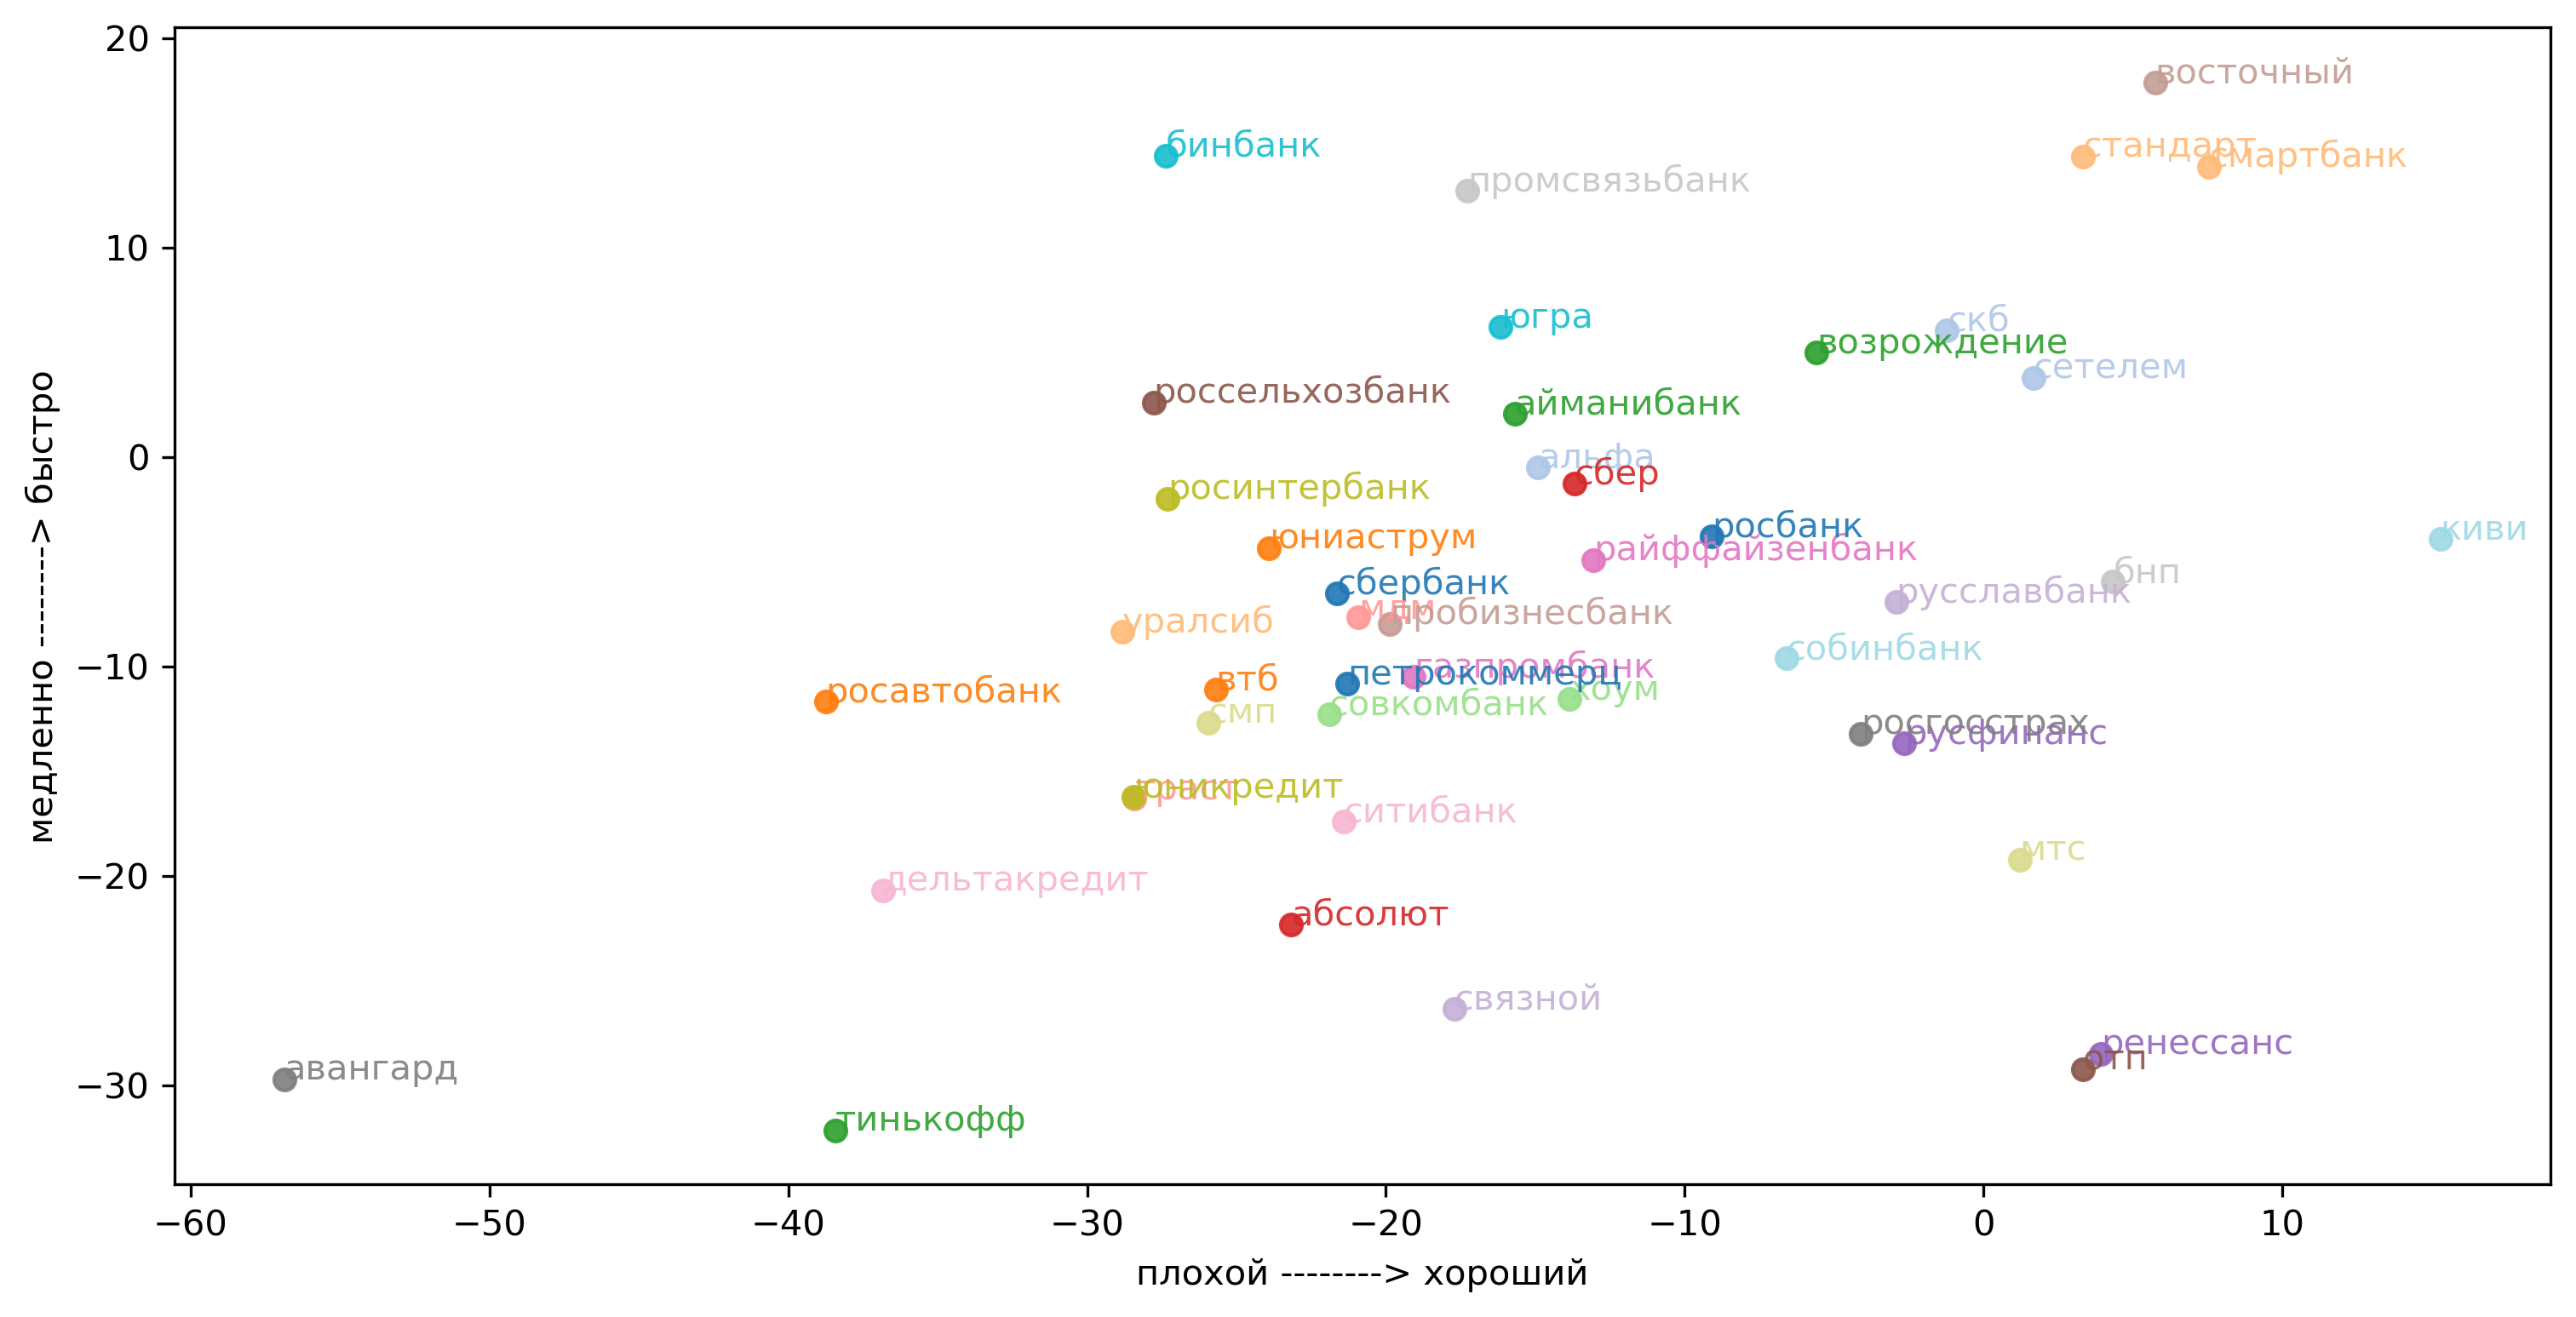

In [368]:
colors = plt.cm.tab20.colors
fig = plt.figure(figsize=(12,6), dpi=300)
ax = fig.add_subplot(1,1,1)

for i in range(len(banks)):
    x, y, text = model[banks[i]].dot(bad_to_good), model[banks[i]].dot(slow_to_fast), banks[i]
    ax.scatter(x, y, alpha=0.9, c=np.array([colors[i%20]]))
    ax.text(x, y, text, alpha=0.9, color=colors[i%20])
    
ax.set_xlabel('плохой --------> хороший')
ax.set_ylabel('медленно --------> быстро')

plt.show()